In [1]:
import pandas as pd
import numpy as np
import random
import math
random.seed(2020)

# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pylab as plt
from sklearn import preprocessing

import lightgbm as lgb
# import xgboost as xgb
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import GradientBoostingClassifier

import missingno as msno
import seaborn as sns

In [2]:
df = pd.read_csv("Train.csv")
# y = df.target
# x = df[["Policy Start Date", "Policy End Date", "Gender", "Age", "First Transaction Date", "No_Pol",
#         "Car_Category", "Subject_Car_Colour", "Subject_Car_Make", "LGA_Name", "State", "ProductName"]]
variables = pd.read_csv("VariableDefinitions.csv")
variables

ID  \
0           Policy Start Date   
1             Policy End Date   
2                      Gender   
3                         Age   
4                 ProductName   
5      First Transaction Date   
6                      No_Pol   
7                Car_Category   
8          Subject_Car_Colour   
9            Subject_Car_Make   
10                   LGA_Name   
11                      State   
12  No_of_claims_3_mon_period   

                           Unique ID for the customer  
0                                 Date policy started  
1                                   Date policy ended  
2                              Gender of the customer  
3                                 Age of the customer  
4                            Name of Insurance policy  
5                         First date payment was made  
6                 Number of policies the customer has  
7                                         Type of car  
8                                          Car colour  
9                                            Car make  
10                    City where policy was purchased  
11                   State where policy was purchased  
12  Wether the customer claimed within a 3 month p...

In [3]:
x = pd.read_csv('Train.csv')
y = x['target'] ; idx_tr = x['ID'] ;
del x['ID'] ; x['First Transaction Date']
# print (x.shape)
#------------------------------Delete duplicated rows--------------------------------------
# with same Target
# print ("Delete duplicated rows:")
num_rows = x.shape[0]
to_del = x.duplicated(keep='first')
x = x[~to_del] ; y = y[~to_del] ; 
# print ("\t*with same Target:",(num_rows-x.shape[0])) 
# With different target
del x['target']
num_rows = x.shape[0]
x_ = x[x.duplicated(keep=False)]
x.drop(x_.index, inplace=True) ; y.drop(x_.index, inplace=True)
# print ("\t*with diff Target:",(num_rows-x.shape[0])) 
# print (x.shape,y.shape)

In [4]:
colors = ['Black', 'Silver', 'Grey', 'Blue', 'White', 'Red', 'Green', 'Gold', 'Ash', 'Wine', 'Brown']
def replace_color(color):
    if color not in colors:
        return random.choice(colors)
    return color
x.Subject_Car_Colour = x.Subject_Car_Colour.apply(replace_color)
le1 = preprocessing.LabelEncoder()
x.Subject_Car_Colour = le1.fit_transform(x.Subject_Car_Colour)

In [5]:
cars = ['Saloon', 'JEEP', 'Truck', 'Bus', 'Mini Bus', 'Pick Up', 'Motorcycle', 'Mini Van', 'Sedan', 'Wagon']
def replace_car(car):
    if car not in cars:
        return random.choice(cars)
    return car
x.Car_Category = x.Car_Category.apply(replace_car)
le2 = preprocessing.LabelEncoder()
x.Car_Category = le2.fit_transform(x.Car_Category)

In [6]:
ages = x.Age.sort_values()
ages[3427] = 60
ages[3518] = 59
ages[5173] = 59
ages[909] = 76
ages[10713] = 76
ages = ages.sort_values()

def fillwith42(x):
    if x >= 15 and x <= 18:
        return 16
    elif x >= 18 and x <= 93:
        return x
    else:
        return 42
    
ages = ages.apply(lambda age: -age if age < 0 else age)
ages = ages.apply(fillwith42)
ages = ages.sort_values()
x.Age = ages

In [7]:
def other_gender(gender):
    if gender not in ["Male", "Female"]:
        return "Other"
    return gender

x.Gender = x.Gender.apply(other_gender)

legender = preprocessing.LabelEncoder()
x.Gender = legender.fit_transform(x.Gender)

In [8]:
le3 = preprocessing.LabelEncoder()
x.ProductName = le3.fit_transform(x.ProductName)

In [9]:
car_brands = ['TOYOTA', 'Honda', 'Lexus', 'Mercedes', 'Hyundai', 'Kia', 'Ford', 'Nissan', 'Volkswagen', 'Range Rover', 'Mitsubishi', 'Iveco', 'BMW', 'ACURA', 'Land Rover', 'Mazda', 'Peugeot', 'Volvo', 'Mack', 'Audi', 'Pontiac', 'Infiniti', 'Chevrolet']
x.Subject_Car_Make = x.Subject_Car_Make.apply(lambda x: x if x in car_brands else "other")
le4 = preprocessing.LabelEncoder()
x.Subject_Car_Make = le4.fit_transform(x.Subject_Car_Make)

In [10]:
lgalist = ['Victoria Island', 'Ikeja', 'Surulere', 'Lagos Island', 'Eti-Osa', 'Lagos Mainland', 'Lekki', 'Abuja Municipal', 'Lagos', 'Ibeju/Lekki', 'Oshodi-Isolo', 'Obia/Akpor', 'Kosofe', 'Abuja', 'Ikoyi', 'Alimosho', 'Benin', 'Amuwo-Odofin', 'Shomolu', 'Port Harcourt', 'Agege', 'Apapa', 'Ikorodu', 'Yaba', 'Port-Harcourt', 'GBAGADA', 'Festac', 'Ajah', 'OGBA', 'Ifako-Ijaye ', 'Ibadan North West', 'Warri Central', 'Central', 'OGUN', 'Warri', 'Ilupeju', 'ENUGU EAST', 'Oredo', 'Ketu', 'Asaba', 'Kaduna North', 'Ibadan South West', 'IBADAN NORTH EAST', 'Oguta', 'Mushin', 'ISHERI', 'OGUDU', 'Abeokuta', 'Ojodu', 'Ife Central', 'Egbeda', 'Isolo', 'Owerri-Municipal', 'Osogbo', 'Maryland', 'Kaduna', 'Ifo', 'Uyo', 'Jos North', 'LGA', 'Kaduna South', 'Oshodi', 'MAGODO', 'Jos South']
x.LGA_Name = x.LGA_Name.apply(lambda x: x if x in lgalist else "other")
le5 = preprocessing.LabelEncoder()
x.LGA_Name = le5.fit_transform(x.LGA_Name)

In [11]:
states = ['Lagos', 'Benue', 'Eti-Osa', 'Abuja-Municipal', 'Ibeju-Lekki', 'Obia-Akpor', 'Oshodi-Isolo', 'Abuja', 'Delta', 'Ogun', 'Edo', 'Amuwo-Odofin', 'Rivers', 'Ibadan-West', 'Port-Harcourt', 'Oyo', 'Ifako-Ijaye', 'Warri-Central', 'Imo', 'ENUGU-EAST', 'Kaduna-North', 'Akwa-Ibom', 'Anambra', 'Osun', 'Ife-Central', 'Niger-State', 'Owerri-Municipal', 'Kaduna', 'Jos-North', 'Jos-South', 'Kaduna-South', 'Anambra-East', 'Ijebu-Ode', 'Enugu-North', 'Ogbmosho-South', 'Ibadan-East', 'Ondo', 'Lagelu-North', 'Ajeromi-Ifelodun', 'Nnewi-North', 'Kano-Municipal', 'Nsit-Ubium', 'ABULE-EGBA', 'Ibadan-North', 'Obafemi-Owode', 'Ogun-Waterside', 'Ado-Ota', 'Aba-North', 'Warri-North', 'Udi-Agwu', 'Aniocha-South', 'Awka-South', 'Onitsha-North', 'Esan-West']
x.State = x.State.apply(lambda x: x if x in states else "other")
le6 = preprocessing.LabelEncoder()
x.State = le6.fit_transform(x.State)

In [12]:
x["Policy Start Date"] = pd.to_datetime(x["Policy Start Date"], format = "%Y-%m-%d")
x["Policy End Date"] = pd.to_datetime(x["Policy End Date"], format = "%Y-%m-%d")
x["First Transaction Date"] = pd.to_datetime(x["First Transaction Date"], format = "%Y-%m-%d")


x["Policy Start Day"] = x["Policy Start Date"].dt.day_of_week
x["Policy Start Month"] = x["Policy Start Date"].dt.month
x["Policy Start Year"] = x["Policy Start Date"].dt.year
del x["Policy Start Date"]

x["Policy End Day"] = x["Policy End Date"].dt.day_of_week
x["Policy End Month"] = x["Policy End Date"].dt.month
x["Policy End Year"] = x["Policy End Date"].dt.year
del x["Policy End Date"]

del x["First Transaction Date"]

In [13]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10274 entries, 0 to 12078
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Gender              10274 non-null  int32
 1   Age                 10274 non-null  int64
 2   No_Pol              10274 non-null  int64
 3   Car_Category        10274 non-null  int32
 4   Subject_Car_Colour  10274 non-null  int32
 5   Subject_Car_Make    10274 non-null  int32
 6   LGA_Name            10274 non-null  int32
 7   State               10274 non-null  int32
 8   ProductName         10274 non-null  int32
 9   Policy Start Day    10274 non-null  int64
 10  Policy Start Month  10274 non-null  int64
 11  Policy Start Year   10274 non-null  int64
 12  Policy End Day      10274 non-null  int64
 13  Policy End Month    10274 non-null  int64
 14  Policy End Year     10274 non-null  int64
dtypes: int32(7), int64(8)
memory usage: 1003.3 KB


In [14]:
x

Gender  Age  No_Pol  Car_Category  Subject_Car_Colour  \
0           1   30       1             6                   1   
1           0   79       1             1                   6   
2           1   43       1             6                   7   
3           1   42       1             2                  10   
5           1   37       2             2                  10   
...       ...  ...     ...           ...                 ...   
12074       0   30       1             6                   1   
12075       0   59       1             4                   1   
12076       1   34       1             8                   8   
12077       2   42       2             6                   9   
12078       0   46       2             1                   1   

       Subject_Car_Make  LGA_Name  State  ProductName  Policy Start Day  \
0                    20        64     54            1                 4   
1                    20        64     54            1                 0   
2                    20        64     54            1                 6   
3                    23        64     54            5                 5   
5                    23        64     54            1                 3   
...                 ...       ...    ...          ...               ...   
12074                19        20     22            1                 1   
12075                23        64     54            1                 6   
12076                23        64     54            5                 6   
12077                20        60     34            0                 5   
12078                10        38     34            1                 3   

       Policy Start Month  Policy Start Year  Policy End Day  \
0                       5               2010               4   
1                      11               2010               0   
2                       3               2010               6   
3                       8               2010               5   
5                      10               2010               3   
...                   ...                ...             ...   
12074                   5               2010               1   
12075                  10               2010               6   
12076                  10               2010               5   
12077                   2               2010               5   
12078                   7               2010               3   

       Policy End Month  Policy End Year  
0                     5             2011  
1                    11             2011  
2                     3             2011  
3                     8             2011  
5                    10             2011  
...                 ...              ...  
12074                 5             2011  
12075                10             2011  
12076                10             2011  
12077                 2             2011  
12078                 6             2011  

[10274 rows x 15 columns]

In [15]:
corr = x.corr()
corr.style.background_gradient(cmap='coolwarm')

<AxesSubplot:>

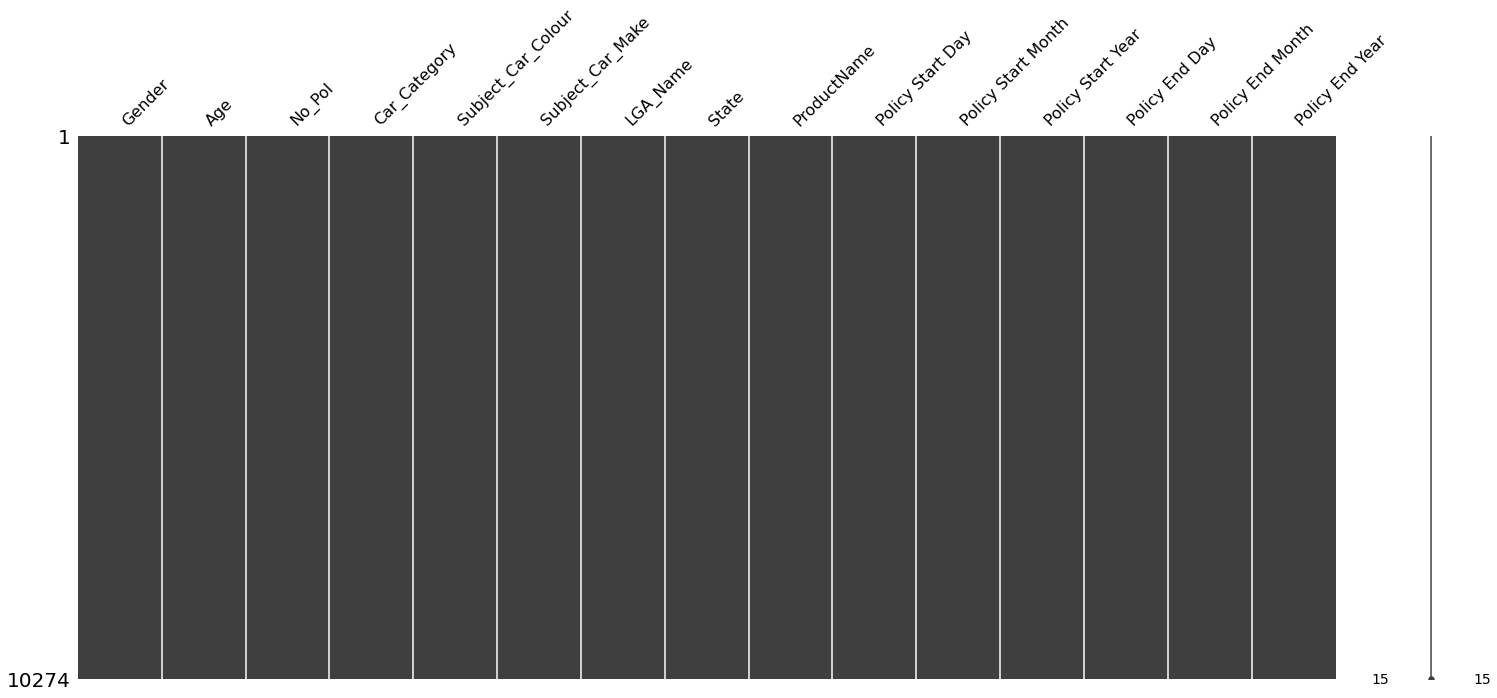

In [16]:
msno.matrix(x)

In [17]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

In [18]:
x

Gender  Age  No_Pol  Car_Category  Subject_Car_Colour  \
0           1   30       1             6                   1   
1           0   79       1             1                   6   
2           1   43       1             6                   7   
3           1   42       1             2                  10   
5           1   37       2             2                  10   
...       ...  ...     ...           ...                 ...   
12074       0   30       1             6                   1   
12075       0   59       1             4                   1   
12076       1   34       1             8                   8   
12077       2   42       2             6                   9   
12078       0   46       2             1                   1   

       Subject_Car_Make  LGA_Name  State  ProductName  Policy Start Day  \
0                    20        64     54            1                 4   
1                    20        64     54            1                 0   
2                    20        64     54            1                 6   
3                    23        64     54            5                 5   
5                    23        64     54            1                 3   
...                 ...       ...    ...          ...               ...   
12074                19        20     22            1                 1   
12075                23        64     54            1                 6   
12076                23        64     54            5                 6   
12077                20        60     34            0                 5   
12078                10        38     34            1                 3   

       Policy Start Month  Policy Start Year  Policy End Day  \
0                       5               2010               4   
1                      11               2010               0   
2                       3               2010               6   
3                       8               2010               5   
5                      10               2010               3   
...                   ...                ...             ...   
12074                   5               2010               1   
12075                  10               2010               6   
12076                  10               2010               5   
12077                   2               2010               5   
12078                   7               2010               3   

       Policy End Month  Policy End Year  
0                     5             2011  
1                    11             2011  
2                     3             2011  
3                     8             2011  
5                    10             2011  
...                 ...              ...  
12074                 5             2011  
12075                10             2011  
12076                10             2011  
12077                 2             2011  
12078                 6             2011  

[10274 rows x 15 columns]

In [19]:
score = 0
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=2020)
evals_results = {}
for train_index, test_index in kf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lgtrain = lgb.Dataset(x_train, y_train)
    lgval = lgb.Dataset(x_test, y_test)
    
    model = lgb.train({'metric':[lgb_f1_score], 'objective': 'binary'},
                     train_set=lgtrain, 
                     valid_sets= [lgval], 
                     valid_names=['valid'], 
                     evals_result=evals_results, 
                     num_boost_round=5000,
                     early_stopping_rounds=100,
                     verbose_eval=-1, 
                     feval=lgb_f1_score
                     )
    
    y_pred = model.predict(x_test)
    scorep = f1_score(np.where(y_pred < 0.5, 0, 1)  , y_test)
    score += scorep
print("lightgbm mean f1_score:", score/5)

C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' 

[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Info] Number of positive: 567, number of negative: 7652
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 14
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Warning] Found whi

C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' 

Early stopping, best iteration is:
[94]	valid's f1: 0.193939
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Info] Number of positive: 566, number of negative: 7653
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 14
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Warning] Found whites

C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' 

Early stopping, best iteration is:
[534]	valid's f1: 0.27027
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Info] Number of positive: 566, number of negative: 7653
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 14
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown 

C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' 

Early stopping, best iteration is:
[335]	valid's f1: 0.208791
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown parameter: 0x0000021B778B7D90>
[LightGBM] [Info] Number of positive: 567, number of negative: 7653
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 8220, number of used features: 14
[LightGBM] [Warning] Unknown parameter: lgb_f1_score
[LightGBM] [Warning] Unknown parameter: at
[LightGBM] [Warning] Unknown

C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\zczak\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' 

Early stopping, best iteration is:
[431]	valid's f1: 0.255556
lightgbm mean f1_score: 0.22449916449916452


In [20]:
# score = 0
# kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=2020)
# for train_index, test_index in kf.split(x, y):
#     x_train, x_test = x.loc[train_index], x.loc[test_index]
#     y_train, y_test = y.loc[train_index], y.loc[test_index]
#     # model = lgb.LGBMClassifier(metric = [lgb_f1_score])
#     model = lgb.LGBMClassifier()
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
#     scorep = f1_score(y_pred, y_test)
#     score += scorep
# print("lightgbm mean f1_score:", score/5)